# Are you on PC or MAC? pc = 0, mac = 1

In [1]:
computer = 1
#! source activate tensorflow

# 1) Libraries

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas_datareader.data as web
import datetime
import pandas as pd
import os
import csv
import glob as glob
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from time import time

matplotlib.rcParams[ 'figure.figsize' ] = ( 20, 6 )

# 2) Import

In [3]:
# Comprehensive way to set the path to Data directory

ROOTPATH = os.getcwd()

path_data = os.path.join(ROOTPATH, 'data')
path_train = os.path.join(path_data, 'train_set')
path_test = os.path.join(path_data, 'test_set')
path_validation = os.path.join(path_data, 'validation_set')

## Import the list of tickers

In [4]:
if computer == 0:
    with open('IBB_holdings.csv', 'r') as csvfile:
        file = csv.reader(csvfile,delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c>=11:
                list_tickers.append(row[0].split(',')[0])
            c+=1

if computer == 1:
    with open('IBB_holdings.csv', 'r', encoding ='mac_roman') as csvfile:
        file = csv.reader(csvfile,delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c>=11:
                list_tickers.append(row[0].split(',')[0])
            c+=1            

list_tickers.sort()
list_tickers.pop()
list_tickers.remove("BLKFDS")
list_tickers.remove("USD")
list_tickers.remove("SNDX")

## Importing functions

In [5]:
def get_data(path):
    list_dataframes=[]
    allFiles = glob.glob(path + "/csv" + "*.csv")
    i = 0
    list_tickers = []
    
    if computer == 0:
        for file_ in allFiles:
            with open(file_, 'r') as csvfile:
                list_dataframes.append(pd.read_csv(csvfile, index_col=None, header=0))
                list_tickers.append(file_.split('_')[4])
                i+=1

    if computer == 1:
        for file_ in allFiles:
            with open(file_, 'r', encoding ='mac_roman') as csvfile:
                list_dataframes.append(pd.read_csv(csvfile, index_col=None, header=0))
                list_tickers.append(file_.split('_')[4])
                i += 1
    
    num_files = i
    
    return num_files, list_dataframes, list_tickers


In [6]:
def normalize_data(num_files, list_dataframes, list_tickers):
    
    maxi = 0
    length = 0
    compt = 0
    j = 0
    
    for df in list_dataframes:
        if len(df) > maxi:
            maxi = len(df['Adj Close'])
    
    data = np.array([np.zeros(maxi)]*(num_files))
    data_normalized = np.array([np.zeros(maxi)]*(num_files))
    
    i = 0
    
    for df in list_dataframes:
        arr = np.array(df['Adj Close'])
        if len(arr) == maxi and not df['Adj Close'].isnull().values.any(): 
            data[j] = arr
            minimum = np.min(arr)
            maximum = np.max(arr)
            arr = (arr - minimum) / (maximum - minimum)
            data_normalized[j] = arr
            j += 1
        else:
            list_tickers.pop(i)
            compt += 1
            i-=1
        i += 1
    
    return data_normalized[:-compt], data[:-compt], list_tickers

## Create training, validation and testing set

In [7]:
train_setDf = get_data(path_train)

validation_setDf = get_data(path_validation)

test_setDf = get_data(path_test)

cross_setDf = (train_setDf[0] + test_setDf[0], train_setDf[1] + test_setDf[1], train_setDf[2] + test_setDf[2])

In [8]:
train_setData_n, train_setData, list_tickers_train = normalize_data(train_setDf[0], train_setDf[1], train_setDf[2])

validation_setData_n, validation_setData, list_tickers_val = normalize_data(validation_setDf[0], validation_setDf[1], validation_setDf[2])

test_setData_n, test_setData, list_tickers_test = normalize_data(test_setDf[0], test_setDf[1], test_setDf[2])

cross_setData_n, cross_setData, list_tickers_cross = normalize_data(cross_setDf[0], cross_setDf[1], cross_setDf[2])

print("train_setData is of length : ",len(train_setData))
print("test_setData is of length : ",len(test_setData))
print("validation_setData is of length : ",len(validation_setData))
print("cross_setData is of length : ",len(cross_setData))

train_setData is of length :  114
test_setData is of length :  28
validation_setData is of length :  27
cross_setData is of length :  142


# Encoding phase

# 3) Functions

## Initializing functions

In [9]:
def weight_variable(num_input, num_output):
    weight_init = tf.random_normal_initializer(stddev=1.0/np.sqrt(num_input))
    weight_shape = [num_input, num_output]
    W = tf.get_variable('W', weight_shape, initializer = weight_init)
    return(W)

def bias_variable(num_output):
    bias_init = tf.constant_initializer(value = 0)
    bias_shape = [num_output]
    b = tf.get_variable('b', bias_shape, initializer = bias_init)
    return(b)

## Fetch data functions

In [10]:
def find_ticker_batch(batch, data_norm, list_tickers):
    true = batch
    index = -1
    i = 0
    while index < 0:
        if data_norm[i][100] - true[100] == 0:
            index = i
        i += 1
    ticker = list_tickers[index]
    return(ticker, index)

## Tensorboard functions

In [11]:
def variable_summary_light(var):
    with tf.variable_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)

In [12]:
def variable_summary(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [13]:
def create_summaries(loss, x, latent, output):
    writer = tf.summary.FileWriter("./logs")
    tf.summary.scalar("Loss", loss)
    layer_grid_summary("Input", x, [28, 28])
    layer_grid_summary("Encoder", latent, [2, 1])
    layer_grid_summary("Output", output, [28, 28])
    return writer, tf.summary.merge_all()

## Training functions

In [14]:
def next_batch(batch_size, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.array(data_shuffle), np.array(labels_shuffle)

In [15]:
def next_fold(i, cross_len):
    
    n = len(cross_setData_n)
    if cross_len > 1:
        test_len = int(n / cross_len)
        init = (i - 1) * test_len
        end = i * test_len

        test_setDn = cross_setData_n[init:end]
        train_setDn = np.concatenate((cross_setData_n[0:init] ,cross_setData_n[end:n]),axis = 0)

        list_tickers_cross_test = list_tickers_cross[init:end]
        list_tickers_cross_train = np.concatenate((list_tickers_cross[0:init] ,list_tickers_cross[end:n]),axis = 0)

        test_setD = cross_setData[init:end]
        train_setD = np.concatenate((cross_setData[0:init] ,cross_setData[end:n]),axis = 0)
    else:
        train_setDn = train_setData_n
        test_setDn = test_setData_n
        list_tickers_cross_train = list_tickers_train
        list_tickers_cross_test = list_tickers_test
        train_setD = train_setData
        test_setD = test_setData
        
    return train_setDn, test_setDn, list_tickers_cross_train, list_tickers_cross_test, train_setD, test_setD

In [16]:
def layer_batch_normalization(x, n_out, phase_train):

    beta_init = tf.constant_initializer(value=0.0, dtype=tf.float32)
    beta = tf.get_variable("beta", [n_out], initializer=beta_init)
    
    gamma_init = tf.constant_initializer(value=1.0, dtype=tf.float32)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_init)

    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    
    def mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
        
    mean, var = tf.cond(phase_train, mean_var_with_update, lambda: (ema_mean, ema_var))

    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-3, True)
    
    return tf.reshape(normed, [-1, n_out])

## Building functions

In [17]:
def layer(input_tensor, num_input, num_output, phase_train, layer_name, bool_drop):
    with tf.variable_scope(layer_name):
        with tf.variable_scope('weights'):
            W = weight_variable(num_input, num_output)
            variable_summary_light(W)
    
        with tf.variable_scope('biases'):
            b = bias_variable(num_output)
            variable_summary_light(W)
            
        
        if bool_drop:
            dropped_or_not = dropout(input_tensor, keep_prob)
        else:
            dropped_or_not = input_tensor
            
        logits = tf.matmul(dropped_or_not, W) + b
            
    return tf.nn.relu(layer_batch_normalization(logits, num_output, phase_train)), W

In [18]:
def encoder(input_tensor, n_code, phase_train):
    with tf.variable_scope("encode"):
        
        with tf.variable_scope('h_1'):
            h_1, W_e_1 = layer(input_tensor, num_input, num_encode_1, phase_train, "encoder", False)
            
        with tf.variable_scope('output'):
            output, W_e_2 = layer(h_1, num_encode_1, n_code, phase_train, "encoder",True)
            
    return output, W_e_2

def decoder(input_tensor, n_code, phase_train):
    with tf.variable_scope("decode"):
        
        with tf.variable_scope('h_1'):
            h_1, W_d_1 = layer(input_tensor, n_code, num_decode_1, phase_train, "encoder",True)
        
        with tf.variable_scope('output'):
            output, W_d_2 = layer(h_1, num_decode_1, num_output, phase_train, "decoder",False)
            
    return output, W_d_2


In [19]:
def dropout(encoder_op, keep_prob):
    with tf.variable_scope("dropped"):
        dropped = tf.nn.dropout(encoder_op, keep_prob)
    return dropped

In [20]:
def mse(output, x):
    with tf.variable_scope('mse'):
        mse = tf.squared_difference(output, x)
    return mse

In [21]:
def regularizer(W_e, W_d):
    with tf.variable_scope("regularizer"):
        regularizer = tf.nn.l2_loss(W_e) + tf.nn.l2_loss(W_d)
    return regularizer

In [22]:
def loss(mse, regularizer, lambd, num_input, batch_size):
    with tf.variable_scope("loss"):
        loss = tf.reduce_sum(mse + lambd * regularizer)/(num_input * batch_size * 2)
    return loss

In [23]:
def training(loss, learning_rate):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)
    return train_op

In [24]:
def evaluate(output, x):
    with tf.variable_scope('validation'):
        
        l2_norm = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(output, x, name="val_diff")), 1))
        
        val_loss = tf.reduce_mean(l2_norm)
        
        val_summary_op = tf.summary.scalar("val_cost", val_loss)
        
        return val_loss, val_summary_op

# 4) Training

## Parameters

In [210]:
# Training Parameters
learning_rate = 0.0008
num_steps = 1000
batch_size = 10
lambd = 0.12
val_dropout = 0.89

display_step = 100

cross_len = 4

# Network Parameters 

num_input = 503 # 503 days considered
num_encode_1 = 250 # 1st layer of encode
n_code = 5  # bottleneck layer
num_decode_1 = 250 # 1st layer of decode
num_output = num_input


date = str(int(time()))

logs_path = '/tmp/tensorflow_logs/autoencoder1/'+date+'/'

## Run the training

In [211]:
#def train_function(train_setDn, test_setDn):
with tf.Graph().as_default():
    with tf.variable_scope("autoencoder_model"):
        
        # Placeholders
        x = tf.placeholder("float", [None, num_input])
        phase_train = tf.placeholder(tf.bool)
        keep_prob = tf.placeholder(tf.float32) #gateway for dropout

        # Extract the latent information (logits from the bottleneck layer)
        code, W_e = encoder(x, n_code, phase_train)

        # Extract the outputs of the autoencoder
        output, W_d = decoder(code, n_code, phase_train)

        cost = loss(mse(output,x), regularizer(W_e, W_d), lambd, num_input, batch_size)

        train_op = training(cost, learning_rate)

        eval_op, val_summary_op = evaluate(output, x)

        # Merge all the summaries - variables, training - into a single operation
        summary_op = tf.summary.merge_all()

        # Save the trained model for later use (testing)
        saver = tf.train.Saver()        

        # Create the session list that will be runned for training
        sess_list = [0] * cross_len
        
        total_loss = np.zeros((cross_len,num_steps))
        total_loss_test = np.zeros(cross_len)
        total_p = [0] * cross_len
        total_batchx = [0] * cross_len
        total_testSetDn = [0] * cross_len
        total_testSetD = [0] * cross_len
        total_tickers_test = [0] * cross_len
        
        start_time = time()
        
        for iteration in range(1,cross_len + 1):
            
            sess_list[iteration-1] = tf.Session()

            # Initialize a summary for our variables during the training
            summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

            # Time to launch the session
            init_op = tf.global_variables_initializer()
            sess_list[iteration - 1].run(init_op)

            steps = [0]*num_steps
            
            next_folder = next_fold(iteration, cross_len)
            
            train_setDn, test_setDn, list_tickers_cross_train, list_tickers_cross_test, train_setD, test_setD = next_folder
                
            total_testSetDn[iteration - 1] = test_setDn
            total_testSetD[iteration - 1] = test_setD
            
            total_tickers_test[iteration - 1] = list_tickers_cross_test
            
            for i in range(1, num_steps + 1):

                # Prepare Data
                total_batch = int(len(train_setData_n) / batch_size)
            

                for j in range(total_batch):
                    mini_batch_x, _ = next_batch(batch_size, train_setDn, train_setDn)

                    _, l, summary = sess_list[iteration-1].run([train_op, cost, summary_op], 
                                feed_dict={x: mini_batch_x, phase_train: True, keep_prob: val_dropout})
                total_loss[iteration-1][i-1] = l
                steps[i-1] = i

                # Write on the log file the datas for TensorBoard / First: summary, Second: overall step
                summary_writer.add_summary(summary, i)

                if i % display_step == 0 or i * iteration == 1:

                    print('Step %i and Iteration %i: Minibatch Loss: %f' % (i, iteration, l))
                    curr_time = time()
                    elapsed_time = curr_time-start_time
                    print('Estimated remaining time = ', (elapsed_time / (num_steps * (iteration - 1) + i) * (num_steps * cross_len - (num_steps * (iteration - 1) + i))),'s\n')

                    # Save the model during the training at save_path
                    #save_path = saver.save(sess, logs_path)
                    #print("Model saved in file: %s" % save_path)

    #                 print("Epoch:", '%04d' % (epoch+1), "cost =", "{:.9f}".format(avg_cost))

    #                 train_writer.add_summary(train_summary, sess.run(global_step))

    #                 validation_loss, in_image, out_image, val_summary = sess.run([eval_op, val_summary_op], feed_dict={x: validation_setData, phase_train: False})

    #                 val_writer.add_summary(in_image, sess.run(global_step))
    #                 val_writer.add_summary(out_image, sess.run(global_step))
    #                 val_writer.add_summary(val_summary, sess.run(global_step))

    #                 print("Validation Loss:", validation_loss)

    #                 save_path = saver.save(sess, model_path)
    #                 print("Model saved in file: %s" % save_path)

    #                 curr_time = time()
    #                 elapsed_time = curr_time-start_time
    #                 print('Estimated remaining time = ', elapsed_time / i * (num_steps-i),'s\n')


    ### Here we plot the latent space (n_code dimension)
            ae_codes, test_loss = sess_list[iteration-1].run([code, cost], 
                                feed_dict={x: test_setData_n, phase_train: False, keep_prob:1})
            fig, ax = plt.subplots()
            ax.scatter(ae_codes[:,0], ae_codes[:,1])
            for i, txt in enumerate(list_tickers_test):
                ax.annotate(txt, (ae_codes[i,0], ae_codes[i,1]))
            
            len_test = len(test_setDn)
            batch_x, _ = next_batch(len_test,test_setDn,test_setDn)
            l , p = sess_list[iteration-1].run([cost, output] , feed_dict={x: batch_x, phase_train: False, keep_prob: 1})
            l = l * batch_size / len_test
            total_loss_test[iteration-1] = l
            total_p[iteration-1] = p
            total_batchx[iteration-1] = batch_x
            print('Minibatch Loss: '+str(l)+'\n\n') 



Step 1 and Iteration 1: Minibatch Loss: 12.567201
Estimated remaining time =  31796.87266945839 s

Step 100 and Iteration 1: Minibatch Loss: 0.035685
Estimated remaining time =  733.1196513175964 s

Step 200 and Iteration 1: Minibatch Loss: 0.036560
Estimated remaining time =  570.851921081543 s



KeyboardInterrupt: 

In [ ]:
for i in range(cross_len):
    print('Mean of error of fold %i: %f' % (i+1, total_loss_test[i]))
MSE = np.mean(total_loss_test)
print('\nTotal mean: ',MSE)

# 8) Exporting

In [ ]:
print("Run the command line:\n" \
          "--> tensorboard --logdir=/tmp/tensorflow_logs/autoencoder1/"+date+"/" \
          "\nThen open http://0.0.0.0:6006/ into your web browser\n\n")
print("Or Run the command line:\n" \
          "--> python -m tensorboard.main --logdir=C:\\tmp\\tensorflow_logs\\autoencoder1\\"+date+"\\" \
          "\nThen open http://desktop-p6qj80l:6006/ into your web browser, or anything the command tells you to type\n\n")

In [ ]:
#! tensorboard --logdir=/tmp/tensorflow_logs/autoencoder1/1519250108/

# 9) Plotting

In [ ]:
#V2
def denormalize(p, batch, dataset_norm, dataset, list_tickers):
    batch_size = len(batch)
    unnormalized_p = {}
    for j in range(batch_size):
        (ticker, index) = find_ticker_batch(batch[j], dataset_norm, list_tickers)

        minimum = np.min(dataset[index])
        maximum = np.max(dataset[index])
        pred = p[j] * (maximum - minimum) + minimum
        unnormalized_p[index] = (ticker, pred)
        
    return unnormalized_p
    
unnormalized_p = denormalize(p, batch_x, test_setDn, test_setD, list_tickers_cross_test)

In [ ]:
for j in unnormalized_p.keys():
    plt.figure()
    plt.plot(unnormalized_p[j][1] ,'r', label = "Prediction")
    plt.hold
    plt.plot(test_setD[j] ,'b',label = "Real Value")
    plt.title(unnormalized_p[j][0])
    plt.legend()
    plt.show;

# 10) Re checking

In [ ]:
diff = abs(p - batch_x)
L2 = np.sqrt(np.multiply(diff,diff))

In [ ]:
for i in L2:
    print(i)

In [ ]:
print('average error in our case = ',np.mean(L2))

In [ ]:
random = np.random.uniform(0,1,(len_test,503))

In [ ]:
diff_random = abs(batch_x - random)
L2_random = np.sqrt(np.multiply(diff_random,diff_random))
print('average error in a random case = ',np.mean(L2_random))

# 11) Finding the commonals

## 11.1) Plot function

In [ ]:
def plot_commonals(p, batch_x, test_setDn, list_tickers_cross_test,fold):
    sorted_by_value = []
    
    diff = abs(p - batch_x)
    L2 = np.sqrt(np.multiply(diff,diff))
    
    for i in range(len(p)):
        sorted_by_value.append((np.mean(L2[i]),i))

    objects =  []
    performance = sorted(sorted_by_value)

    for i in performance:
        ticker, index = find_ticker_batch(batch_x[i[1]], test_setDn, list_tickers_cross_test)
        objects.append(ticker)


    y_pos = np.arange(len(objects))
    plotable_performance = [i[0] for i in performance]

    
    plt.figure()
    plt.bar(y_pos, plotable_performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Score')
    plt.title('Communals of fold '+str(fold + 1))

    plt.show();

## 11.2) Plot for each fold

In [ ]:
all_test_p = []
all_test_batch = []
all_test_test_setDn = []
all_test_test_setD = []
all_test_list_tickers = []

for fold in range(cross_len):
    p = total_p[fold]
    batch_x = total_batchx[fold]
    test_setDn = total_testSetDn[fold]
    test_setD = total_testSetD[fold]
    list_tickers_cross_test = total_tickers_test[fold]
    plot_commonals(p, batch_x, test_setDn, list_tickers_cross_test,fold)
    
    all_test_p += list(p)
    all_test_batch += list(batch_x)
    all_test_test_setDn += list(test_setDn)
    all_test_test_setD += list(test_setD)
    all_test_list_tickers += list(list_tickers_cross_test)


## 11.3) Plot for the whole test batch

In [ ]:
p = np.array(all_test_p)
batch_x = np.array(all_test_batch)
test_setDn = all_test_test_setDn
test_setD = all_test_test_setD
list_tickers_cross_test = all_test_list_tickers

plot_commonals(p, batch_x, test_setDn, list_tickers_cross_test,-1)


# 12) Storing values for memory

In [ ]:
fields = ['learning_rate', 'num_steps', 'batch_size', 'lambd', 'val_dropout', 'cross_len', 'num_encode_1', 'n_code', 'MSE']
values = [learning_rate, num_steps, batch_size, lambd, val_dropout, cross_len, num_encode_1, n_code, MSE]

In [ ]:
ROOTPATH = os.getcwd()

if not os.path.isfile('results.csv'):
    if computer == 0:
        with open('results.csv', 'a') as csvfile:
            spamwriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
            spamwriter.writerow(fields)
    else:
        with open('results.csv', 'a', encoding ='mac_roman') as csvfile:
            spamwriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
            spamwriter.writerow(fields)


if computer == 0:
    with open('results.csv', 'a') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
        spamwriter.writerow(values)
else:
    with open('results.csv', 'a', encoding ='mac_roman') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
        spamwriter.writerow(values)
        


# Calibration phase

# 1) Operating functions

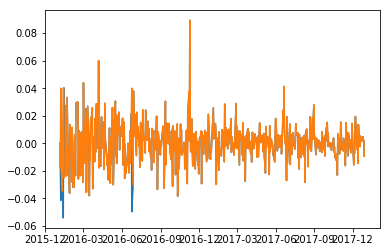

In [78]:
def rateOfReturnWeekly(df,shift):
    
    # Making sure dataframe is well sorted
    df_sorted = df.sort_index( ascending = True )
    

    #Be careful with the shift!
    df_shifted = df_sorted.shift(shift)
    rate_of_returns = (df_sorted - df_shifted) / df_shifted
    for i in range(shift):
        rate_of_returns = rate_of_returns.drop(rate_of_returns.index[0])

    return rate_of_returns

In [ ]:
def logRateOfReturnWeekly(df,shift):
    
    # Making sure dataframe is well sorted
    df_sorted = df.sort_index( ascending = True )
    

    #Be careful with the shift!
    df_shifted = df_sorted.shift(shift)
    log_rate_of_returns = np.log(df_sorted / df_shifted)
    for i in range(shift):
        log_rate_of_returns = log_rate_of_returns.drop(log_rate_of_returns.index[0])

    return log_rate_of_returns

In [ ]:
def modify_benchmark(df,column,threshold,shift):
    rate = rateOfReturnWeekly(df,shift)
    for i in range(len(rate[column])):
        if rate[column][i] <= - threshold:
            rate[column][i] = threshold
    return rate

In [ ]:
def reconstruct(rates):
    prices = [1]
    for i in range(len(rates)):
        prices.append( (rates[i] + 1) * prices[i])
    return prices

# 2) Import data

In [ ]:
ROOTPATH = os.getcwd()

path_data = os.path.join(ROOTPATH, 'data')

file = path_data+"/csv_IBB_from_2016-01-01_to_2018-01-01.csv"

if computer == 0:
    with open(file, 'r') as csvfile:
        benchmark = pd.read_csv(csvfile, index_col=None, header=0)
        benchmark = benchmark.set_index(pd.DatetimeIndex(benchmark["Date"]))
        del benchmark["Date"]
        
if computer == 1:
    with open(file, 'r', encoding ='mac_roman') as csvfile:
        benchmark = pd.read_csv(csvfile, index_col=None, header=0)
        benchmark = benchmark.set_index(pd.DatetimeIndex(benchmark["Date"]))
        del benchmark["Date"]

In [ ]:
shift_calib = 1
threshold = 0.04

rate = rateOfReturnWeekly(benchmark,shift_calib)
plt.plot(rate['Adj Close'])
plt.show;

rate2 = modify_benchmark(benchmark,'Adj Close',threshold,shift_calib)
plt.plot(rate2['Adj Close'])
plt.show;

In [218]:
print(int(np.floor(rate['Adj Close'].shape[0]*0.75)))

376


# 3) Calibration network functions

In [42]:
def layer1_calib(input_tensor, S, n_code, phase_train):
    with tf.variable_scope("calib"):
            
        with tf.variable_scope('output'):
            output, W_e = layer(input_tensor, S, n_code, phase_train, "encoder",True)
            
    return output, W_e

def layer2_calib(input_tensor, S, n_code, phase_train):
    with tf.variable_scope("decode"):
        
        with tf.variable_scope('output'):
            output, W_d = layer(input_tensor, n_code, S, phase_train, "decoder",False)
            
    return tf.nn.softmax(output), W_d

# 4) Import least/most commonals

In [43]:
# batch_x is the array of initial rate of returns
# p is the array of predictions
# S is the number of "most commonals"
# Take the 10 most commonals, plus the S - 10 least commonals

def return_commonals(S,p,batch_x): 
    sorted_by_value = []
    
    diff = abs(p - batch_x)
    L2 = np.sqrt(np.multiply(diff,diff))
    
    for i in range(len(p)):
        sorted_by_value.append((np.mean(L2[i]),i))
    
    performance = sorted(sorted_by_value)

    objects= []
    for i in performance:
        ticker, index = find_ticker_batch(batch_x[i[1]], test_setDn, list_tickers_cross_test)
        objects.append(ticker)
    
    list_commonals =  []
    
    for i in range(10):
        list_commonals.append([objects[i],batch_x[performance[i][1]]])
    
    for i in range(S-10):
        list_commonals.append([objects[-i],batch_x[performance[-i][1]]])
    
    return(list_commonals)

In [44]:
# Training Parameters
S = 65

stock_list = [return_commonals(S, p, batch_x)[i][1] for i in range(S)]
ticker_list_calib = [return_commonals(S, p, batch_x)[i][0] for i in range(S)]



len_list = len(stock_list)
stock_list_unnorm = []
for j in range(len_list):
    _, index = find_ticker_batch(stock_list[j], test_setDn, list_tickers_cross_test)

    minimum = np.min(test_setD[index])
    maximum = np.max(test_setD[index])
    stock_list_unnorm.append(stock_list[j] * (maximum - minimum) + minimum)

    
stock_arr = np.array(stock_list_unnorm).transpose()


# 5) Set network parameters

In [ ]:
#train_setData_n, train_setData, list_tickers_train

learning_rate_calib = 0.0001
num_steps_calib = 10000
batch_size_calib = 10
lambd_calib = 0.2
val_dropout_calib = 0.85

display_step_calib = 1000

cross_len_calib = 1


# Network Parameters 

num_input_calib = S
n_hidden_calib = 5  # bottleneck layer
num_output_calib = S

# 6) Get the output and the input

In [45]:
# Output : benchmark of the IBB
y = rate2['Adj Close']
y = y.tolist()

In [46]:
stock2 = rateOfReturnWeekly(pd.DataFrame(stock_arr),shift_calib)

In [47]:
stock_list_2 = []
for i in stock2.columns:
    stock_list_2.append(list(stock2[i]))
stock_list_2 = np.array(stock_list_2).transpose()

# 7) Training functions

In [48]:
def next_batch_calib(batch_size, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[0]
    data_shuffle = data[idx]
    labels_shuffle = labels[idx]

    return np.array(data_shuffle), np.array(labels_shuffle)

In [ ]:
def next_batch(batch_size, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [list(data[i]) for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.array(data_shuffle), np.array(labels_shuffle)

In [241]:
def time_split_calib(df):
    # Will produce the 75% / 25% train and test data for the calibration phase
    index_rows = np.arange(df.shape[0])
    bound_train = int(np.floor(df.shape[0]*0.75))
    index_train = np.arange(bound_train)
    
    index_test = [x for x in index_rows if (x not in(index_train))]
    
    train_df = df.iloc[index_train]
    test_df = df.iloc[index_test]
                              
    return train_df, test_df

In [239]:
df_train, df_test = time_split_calib(rate)

In [240]:
df_test.shape

(126, 6)

In [ ]:
def next_fold(i, cross_len):
    
    n = len(cross_setData_n)
    if cross_len > 1:
        test_len = int(n / cross_len)
        init = (i - 1) * test_len
        end = i * test_len

        test_setDn = cross_setData_n[init:end]
        train_setDn = np.concatenate((cross_setData_n[0:init] ,cross_setData_n[end:n]),axis = 0)

        list_tickers_cross_test = list_tickers_cross[init:end]
        list_tickers_cross_train = np.concatenate((list_tickers_cross[0:init] ,list_tickers_cross[end:n]),axis = 0)

        test_setD = cross_setData[init:end]
        train_setD = np.concatenate((cross_setData[0:init] ,cross_setData[end:n]),axis = 0)
    else:
        train_setDn = train_setData_n
        test_setDn = test_setData_n
        list_tickers_cross_train = list_tickers_train
        list_tickers_cross_test = list_tickers_test
        train_setD = train_setData
        test_setD = test_setData
        
    return train_setDn, test_setDn, list_tickers_cross_train, list_tickers_cross_test, train_setD, test_setD

# 8) Training

In [49]:
#def train_function(train_setDn, test_setDn):
with tf.Graph().as_default():
    with tf.variable_scope("calibration_phase"):
        
        # Placeholders
        x = tf.placeholder("float", [None, S])
        label = tf.placeholder("float", [None,1])
        
        phase_train = tf.placeholder(tf.bool)
        keep_prob = tf.placeholder(tf.float32) #gateway for dropout

        # Extract the latent information (logits from the bottleneck layer)
        hidden, W_e = layer1_calib(x, S, n_hidden_calib, phase_train)

        # Extract the outputs of the autoencoder
        output, W_d = layer2_calib(hidden, S, n_hidden_calib, phase_train)
        
        
        rr_tot = np.dot(output, x)
    
#         error = (rr_tot - bench_day)**2
        
        cost = loss(mse(rr_tot, label), regularizer(W_e, W_d), lambd_calib, num_input_calib, batch_size_calib)

        train_op = training(cost, learning_rate_calib)

        eval_op, val_summary_op = evaluate(rr_tot, label)

        # Merge all the summaries - variables, training - into a single operation
        summary_op = tf.summary.merge_all()

        # Save the trained model for later use (testing)
        saver = tf.train.Saver()        

        # Create the session list that will be runned for training
        
        total_loss = np.zeros(num_steps_calib)
        
        
        start_time = time()
        
        session = tf.Session()
        
        init_op = tf.global_variables_initializer()
        session.run(init_op)
        
        summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
        
        for i in range(1, num_steps_calib + 1):
            
            
            total_batch = int(len(stock_list_2) / batch_size_calib)

            for j in range(total_batch):
                mini_batch_x, mini_batch_y = next_batch(batch_size_calib, stock_list_2, y)


            _, l, summary = session.run([train_op, cost, summary_op], 
                            feed_dict={x: mini_batch_x , label: mini_batch_y.reshape((batch_size_calib,1)), phase_train: True, keep_prob: val_dropout_calib})
            
            
            total_loss[i-1] = l
            
            summary_writer.add_summary(summary, i)
            
            if i % display_step == 0 or i * iteration == 1:

                    print('Step %i : Minibatch Loss: %f' % (i, l))
                    curr_time = time()
                    elapsed_time = curr_time-start_time
                    print('Estimated remaining time = ', elapsed_time / i * (num_steps_calib-i),'s\n')
                    
        batch_size_verif = len(y)
        #mini_batch_x, mini_batch_y = next_batch(batch_size, stock_list_2, y)
        
        lll=[]
        for i in y:
            lll.append([i])
        mini_batch_x, mini_batch_y = stock_list_2, lll
        
        #p_calib = session.run([output] , feed_dict={x: mini_batch_x , label: mini_batch_y.reshape((batch_size,1)), phase_train: True, keep_prob: 1})
        p_calib = session.run(output , feed_dict={x: mini_batch_x , label: mini_batch_y, phase_train: True, keep_prob: 1})
        


Step 100 : Minibatch Loss: 3.246140
Estimated remaining time =  599.634801864624 s

Step 200 : Minibatch Loss: 3.114215
Estimated remaining time =  409.09012246131897 s

Step 300 : Minibatch Loss: 2.989925
Estimated remaining time =  333.5225133895874 s

Step 400 : Minibatch Loss: 2.872127
Estimated remaining time =  298.17610359191895 s

Step 500 : Minibatch Loss: 2.760535
Estimated remaining time =  270.74761271476746 s

Step 600 : Minibatch Loss: 2.654585
Estimated remaining time =  250.2918144861857 s

Step 700 : Minibatch Loss: 2.553662
Estimated remaining time =  236.86603638104032 s

Step 800 : Minibatch Loss: 2.457554
Estimated remaining time =  229.44807291030884 s

Step 900 : Minibatch Loss: 2.365856
Estimated remaining time =  225.359429942237 s

Step 1000 : Minibatch Loss: 2.278178
Estimated remaining time =  221.3134217262268 s

Step 1100 : Minibatch Loss: 2.194416
Estimated remaining time =  214.37899429147893 s

Step 1200 : Minibatch Loss: 2.114125
Estimated remaining ti

Step 9600 : Minibatch Loss: 0.069165
Estimated remaining time =  8.83921355009079 s

Step 9700 : Minibatch Loss: 0.065766
Estimated remaining time =  6.625717118843315 s

Step 9800 : Minibatch Loss: 0.062733
Estimated remaining time =  4.414869736651985 s

Step 9900 : Minibatch Loss: 0.059635
Estimated remaining time =  2.207949426439073 s

Step 10000 : Minibatch Loss: 0.056773
Estimated remaining time =  0.0 s



In [50]:
calibration = []
for i in range(len(p_calib)):
    mini_batch_x_keep = mini_batch_x[i]
    p_keep = p_calib[i]
    product = np.sum(np.dot(p_keep,mini_batch_x_keep))
    calibration.append(product)

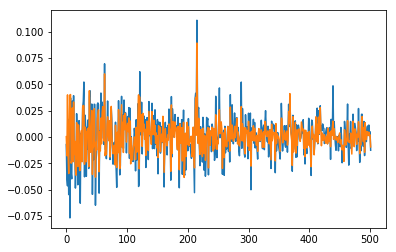

In [51]:
plt.plot(calibration)
plt.plot(mini_batch_y)
plt.show();

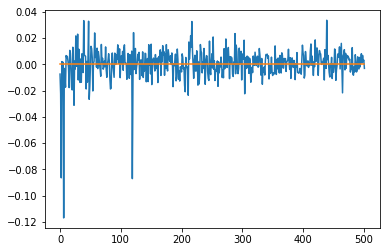

In [52]:
mne = [0]*batch_size_verif

plt.plot(np.array(calibration)-np.array(y))
plt.plot(mne)
plt.show();

# 9) Plot the outcomes of the training

In [53]:
avg_rateOfReturn_calib = np.array(calibration).mean()

In [54]:
np.array(mini_batch_y).mean()

0.0006134829147771628

In [55]:
print(rate['Adj Close'].mean())
print(rate2['Adj Close'].mean())

8.441781062859554e-05
0.0006134829147771628


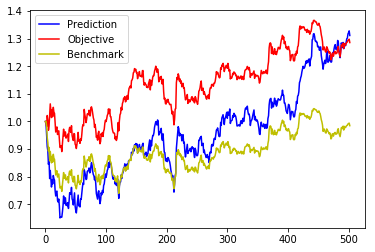

In [56]:
result_prices = reconstruct(calibration)
expected_prices = reconstruct(rate2['Adj Close'])
reconstruct_real_prices = reconstruct(rate['Adj Close'])
plt.plot(result_prices,'b', label = "Prediction")
plt.plot(expected_prices,'r', label = "Objective")
plt.plot(reconstruct_real_prices,'y', label = "Benchmark")
plt.legend()
plt.show();

In [57]:
len(p_calib)

502

# 10) Storing and writing values for memory

In [58]:
fields = ['learning_rate_calib', 'num_steps_calib', 'batch_size_calib', 'lambd_calib', 'val_dropout_calib', 'cross_len_calib', 'S', 'Threshold', 'n_hidden_calib', 'avg_rateOfReturn_calib']
values = [learning_rate_calib, num_steps_calib, batch_size_calib, lambd_calib, val_dropout_calib, cross_len_calib, S, -threshold , n_hidden_calib, avg_rateOfReturn_calib]

In [59]:
ROOTPATH = os.getcwd()

if not os.path.isfile('results_calib.csv'):
    if computer == 0:
        with open('results_calib.csv', 'a') as csvfile:
            spamwriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
            spamwriter.writerow(fields)
    else:
        with open('results_calib.csv', 'a', encoding ='mac_roman') as csvfile:
            spamwriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
            spamwriter.writerow(fields)


if computer == 0:
    with open('results_calib.csv', 'a') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
        spamwriter.writerow(values)
else:
    with open('results_calib.csv', 'a', encoding ='mac_roman') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
        spamwriter.writerow(values)